In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext, ROUND_HALF_UP
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import cm
from scipy import stats
import statsmodels.formula.api as smf
import patsy

# Fig. 2a

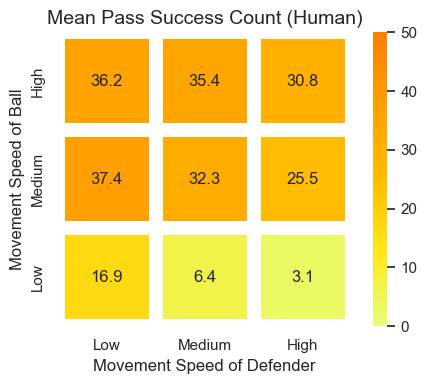

In [3]:

alphabets = list("ABCDEFGHI")  # A〜I

pass_matrix = []
for alphabet_num in range(9):
    
    pass_count_end_episode_sub = []
    for sub_num in range(28):
        
        pass_count_end_episode = []
        for con_num in range(3):
            con_alphabet = alphabets[alphabet_num]
            sub = '{0:03d}'.format(sub_num + 1)
            condition = con_alphabet + str(con_num + 1)
            load_name = f"../data/sub/sub{sub}/sub{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)
            
            for episode in range(8):
                pos_episode = pos_list[episode]
                pass_times_episode = pos_episode[7]
                pass_count_end_episode.append(pass_times_episode[-1])

        pass_count_end_episode_sub.append(np.mean(pass_count_end_episode))
            
    pass_matrix.append(pass_count_end_episode_sub)

pass_matrix = np.array(pass_matrix).reshape(3, 3, 28)


# plot
mean_matrix = pass_matrix.mean(axis=2)

annot_labels = np.empty_like(mean_matrix, dtype=object)
for i in range(3):
    for j in range(3):
        m = mean_matrix[i, j]
        annot_labels[i, j] = f"{m:.1f}"

plt.figure(figsize=(5, 4))
sns.set(style='white')

ax = sns.heatmap(mean_matrix, annot=annot_labels, fmt='', cmap="Wistia", vmin=0, vmax=50,
                 xticklabels=["Low", "Medium", "High"],
                 yticklabels=["Low", "Medium", "High"], 
                 linewidths=10, linecolor='white', cbar=True, square=True)

ax.invert_yaxis()
plt.title("Mean Pass Success Count (Human)", fontsize=14)
plt.xlabel("Movement Speed of Defender")
plt.ylabel("Movement Speed of Ball")
plt.tight_layout()
plt.show()


# Fig. 2b

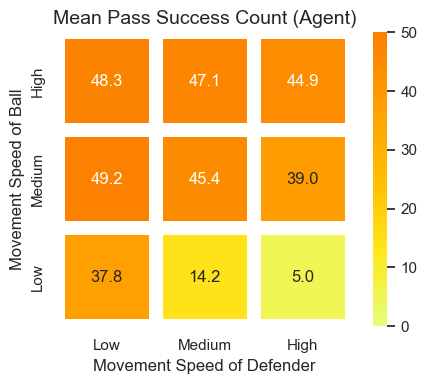

In [4]:

alphabets = list("ABCDEFGHI")  # A〜I

agent_pass_matrix = []
for alphabet_num in range(9):
    
    pass_count_end_episode_sub = []
    for sub_num in range(28):
        
        pass_count_end_episode = []
        for con_num in range(3):
            con_alphabet = alphabets[alphabet_num]
            sub = '{0:03d}'.format(sub_num + 1)
            condition = con_alphabet + str(con_num + 1)
            load_name = f"../data/agent/max_sigma/max_50/sigma_0/agent{sub}/agent{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)

            for episode in range(8):
                pos_episode = pos_list[episode]
                pass_times_episode = pos_episode[7]
                pass_count_end_episode.append(pass_times_episode[-1])

        pass_count_end_episode_sub.append(np.mean(pass_count_end_episode))

    agent_pass_matrix.append(pass_count_end_episode_sub)

agent_pass_matrix = np.array(agent_pass_matrix).reshape(3, 3, 28)


# plot
agent_mean_matrix = agent_pass_matrix.mean(axis=2)

agent_annot_labels = np.empty_like(agent_mean_matrix, dtype=object)
for i in range(3):
    for j in range(3):
        m = agent_mean_matrix[i, j]
        agent_annot_labels[i, j] = f"{m:.1f}"

plt.figure(figsize=(5, 4))
sns.set(style='white')

ax = sns.heatmap(agent_mean_matrix, annot=agent_annot_labels, fmt='', cmap="Wistia", vmin=0, vmax=50,
                 xticklabels=["Low", "Medium", "High"],
                 yticklabels=["Low", "Medium", "High"],
                 linewidths=10, linecolor='white', cbar=True, square=True)

ax.invert_yaxis()
plt.title("Mean Pass Success Count (Agent)", fontsize=14)
plt.xlabel("Movement Speed of Defender")
plt.ylabel("Movement Speed of Ball")
plt.tight_layout()
plt.show()


# Fig. 2c

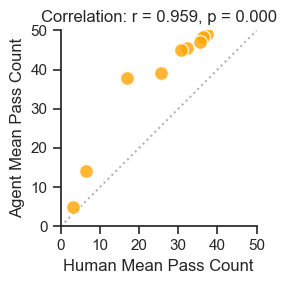

In [5]:

human_vals = np.array(mean_matrix).flatten()
agent_vals = np.array(agent_mean_matrix).flatten()

r, p = pearsonr(human_vals, agent_vals)

title_prefix="Correlation"
point_size=100

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([0, 50], [0, 50], linestyle='dotted', color='gray', alpha=0.6, zorder=0)
ax.scatter(human_vals, agent_vals, color='orange', edgecolor='white', s=point_size, zorder=1, alpha=0.8)
ax.set_xlabel("Human Mean Pass Count")
ax.set_ylabel("Agent Mean Pass Count")
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_yticks([0, 10, 20, 30, 40, 50])
ax.set_aspect('equal', adjustable='box')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.tick_params(
    axis='both', direction='out', length=6, width=1.2,
    bottom=True, top=False, left=True, right=False
)
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
ax.set_title(f"{title_prefix}: r = {r:.3f}, p = {p:.3f}")
plt.tight_layout()
plt.show()


# Fig. 2d-f

In [6]:
def initial_pass_check(attacker1_pos_episode, attacker2_pos_episode, attacker3_pos_episode, ball_pos_episode, threshold=1e-2):
    dist_now_1 = np.linalg.norm(attacker1_pos_episode[0] - ball_pos_episode[0])
    dist_now_2 = np.linalg.norm(attacker2_pos_episode[0] - ball_pos_episode[0])
    dist_now_3 = np.linalg.norm(attacker3_pos_episode[0] - ball_pos_episode[0])
    
    if dist_now_1 > threshold and dist_now_2 > threshold and dist_now_3 > threshold:
        if dist_now_1 < dist_now_2 and dist_now_1 < dist_now_3:
            pass_outcome_a1 = 1
            pass_outcome_a2 = 0
            pass_outcome_a3 = 0
        elif dist_now_2 < dist_now_1 and dist_now_2 < dist_now_3:
            pass_outcome_a1 = 0
            pass_outcome_a2 = 1
            pass_outcome_a3 = 0
        elif dist_now_3 < dist_now_1 and dist_now_3 < dist_now_2:
            pass_outcome_a1 = 0
            pass_outcome_a2 = 0
            pass_outcome_a3 = 1
    
    else:
        pass_outcome_a1 = 0
        pass_outcome_a2 = 0
        pass_outcome_a3 = 0

    return pass_outcome_a1, pass_outcome_a2, pass_outcome_a3


def last_pass_check(defender_pos_episode, ball_pos_episode, threshold=1e-2):
    dist_now = np.linalg.norm(defender_pos_episode[-1] - ball_pos_episode[-1])
    
    if dist_now < threshold:
        last_pass = 0
    else:
        last_pass = 1

    return last_pass


def get_last_pass_index(pass_outcome):
    try:
        return len(pass_outcome) - 1 - pass_outcome[::-1].index(1)
    except ValueError:
        return -1


In [7]:

all_pass_rate_a1 = []
all_pass_rate_a2 = []
all_pass_rate_a3 = []

for sub_num in range(28):

    pass_rate_a1 = []
    pass_rate_a2 = []
    pass_rate_a3 = []

    for alphabet_num in range(len(alphabets)):

        pass_outcome_a1 = []
        pass_outcome_a2 = []
        pass_outcome_a3 = []

        for con_num in range(3):

            con_alphabet = alphabets[alphabet_num]       
            sub = '{0:03d}'.format(sub_num + 1)
            condition = con_alphabet + str(con_num + 1)  
            load_name = "../data/sub/sub" + sub + "/sub" + sub + "_" + condition + ".npy"
            pos_list = np.load(load_name, allow_pickle=True)
            
            for episode in range(8):

                pass_episode_a1 = []
                pass_episode_a2 = []
                pass_episode_a3 = []
                
                pos_episode = pos_list[episode]
                defender_pos_episode = pos_episode[0]
                attacker1_pos_episode = pos_episode[1]
                attacker2_pos_episode = pos_episode[2]
                attacker3_pos_episode = pos_episode[3]
                ball_pos_episode = pos_episode[4]

                pass_a1, pass_a2, pass_a3 = initial_pass_check(attacker1_pos_episode, attacker2_pos_episode, attacker3_pos_episode, ball_pos_episode)
                pass_episode_a1.append(pass_a1)
                pass_episode_a2.append(pass_a2)
                pass_episode_a3.append(pass_a3)
                
                if pass_a1==1:
                    pass_outcome_a1.append(pass_a1)
                elif pass_a2:
                    pass_outcome_a2.append(pass_a2)
                elif pass_a3:
                    pass_outcome_a3.append(pass_a3)
                
                threshold = 1e-2
                for t in range(len(defender_pos_episode) - 1):                
                    
                    # attacker1
                    dist_now_1 = np.linalg.norm(attacker1_pos_episode[t] - ball_pos_episode[t])
                    dist_next_1 = np.linalg.norm(attacker1_pos_episode[t+1] - ball_pos_episode[t+1])
                    
                    if dist_now_1 < threshold and dist_next_1 >= threshold:
                        pass_episode_a1.append(1)
                        pass_outcome_a1.append(1)
                    else:
                        pass_episode_a1.append(0)

                    # attacker2
                    dist_now_2 = np.linalg.norm(attacker2_pos_episode[t] - ball_pos_episode[t])
                    dist_next_2 = np.linalg.norm(attacker2_pos_episode[t+1] - ball_pos_episode[t+1])
                    if dist_now_2 < threshold and dist_next_2 >= threshold:
                        pass_episode_a2.append(1)
                        pass_outcome_a2.append(1)
                    else:
                        pass_episode_a2.append(0)
                            
                    # attacker3
                    dist_now_3 = np.linalg.norm(attacker3_pos_episode[t] - ball_pos_episode[t])
                    dist_next_3 = np.linalg.norm(attacker3_pos_episode[t+1] - ball_pos_episode[t+1])
                    if dist_now_3 < threshold and dist_next_3 >= threshold:
                        pass_episode_a3.append(1)
                        pass_outcome_a3.append(1)
                    else:
                        pass_episode_a3.append(0)
                    
                last_pass = last_pass_check(defender_pos_episode, ball_pos_episode)                 
                dist_next_b = np.linalg.norm(ball_pos_episode[-1] - np.array([0, 0]))
                if last_pass == 0 or dist_next_b >= 0.8:
                    
                    idx_a1 = get_last_pass_index(pass_episode_a1)
                    idx_a2 = get_last_pass_index(pass_episode_a2)
                    idx_a3 = get_last_pass_index(pass_episode_a3)

                    last_idx = max(idx_a1, idx_a2, idx_a3)

                    if last_idx == idx_a1:
                        last_passer = "a1"
                    elif last_idx == idx_a2:
                        last_passer = "a2"
                    elif last_idx == idx_a3:
                        last_passer = "a3"
                    else:
                        last_passer = "none"
                        
                    if last_passer == "a1":
                        pass_outcome_a1[-1] = 0
                    elif last_passer == "a2":
                        pass_outcome_a2[-1] = 0
                    elif last_passer == "a3":
                        pass_outcome_a3[-1] = 0

        pass_rate_a1.append(np.mean(pass_outcome_a1))
        pass_rate_a2.append(np.mean(pass_outcome_a2))
        pass_rate_a3.append(np.mean(pass_outcome_a3))

    all_pass_rate_a1.append(pass_rate_a1)
    all_pass_rate_a2.append(pass_rate_a2)
    all_pass_rate_a3.append(pass_rate_a3)

all_pass_rate_a1 = np.array(all_pass_rate_a1).T
all_pass_rate_a2 = np.array(all_pass_rate_a2).T
all_pass_rate_a3 = np.array(all_pass_rate_a3).T

print("Finish!")

Finish!


In [9]:

all_pass_rate_a1_agent = []
all_pass_rate_a2_agent = []
all_pass_rate_a3_agent = []

for sub_num in range(28):

    pass_rate_a1 = []
    pass_rate_a2 = []
    pass_rate_a3 = []

    for alphabet_num in range(len(alphabets)):

        pass_outcome_a1 = []
        pass_outcome_a2 = []
        pass_outcome_a3 = []

        for con_num in range(3):

            con_alphabet = alphabets[alphabet_num]       
            sub = '{0:03d}'.format(sub_num + 1)
            condition = con_alphabet + str(con_num + 1)
            
            load_name = f"../data/agent/max_sigma/max_50/sigma_0/agent{sub}/agent{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)
            
            for episode in range(8):

                pass_episode_a1 = []
                pass_episode_a2 = []
                pass_episode_a3 = []
                
                pos_episode = pos_list[episode]
                defender_pos_episode = pos_episode[0]
                attacker1_pos_episode = pos_episode[1]
                attacker2_pos_episode = pos_episode[2]
                attacker3_pos_episode = pos_episode[3]
                ball_pos_episode = pos_episode[4]

                pass_a1, pass_a2, pass_a3 = initial_pass_check(attacker1_pos_episode, attacker2_pos_episode, attacker3_pos_episode, ball_pos_episode)
                pass_episode_a1.append(pass_a1)
                pass_episode_a2.append(pass_a2)
                pass_episode_a3.append(pass_a3)
                
                if pass_a1==1:
                    pass_outcome_a1.append(pass_a1)
                elif pass_a2:
                    pass_outcome_a2.append(pass_a2)
                elif pass_a3:
                    pass_outcome_a3.append(pass_a3)
                
                threshold = 1e-2
                for t in range(len(defender_pos_episode) - 1):                
                    
                    # attacker1
                    dist_now_1 = np.linalg.norm(attacker1_pos_episode[t] - ball_pos_episode[t])
                    dist_next_1 = np.linalg.norm(attacker1_pos_episode[t+1] - ball_pos_episode[t+1])
                    
                    if dist_now_1 < threshold and dist_next_1 >= threshold:
                        pass_episode_a1.append(1)
                        pass_outcome_a1.append(1)
                    else:
                        pass_episode_a1.append(0)

                    # attacker2
                    dist_now_2 = np.linalg.norm(attacker2_pos_episode[t] - ball_pos_episode[t])
                    dist_next_2 = np.linalg.norm(attacker2_pos_episode[t+1] - ball_pos_episode[t+1])
                    if dist_now_2 < threshold and dist_next_2 >= threshold:
                        pass_episode_a2.append(1)
                        pass_outcome_a2.append(1)
                    else:
                        pass_episode_a2.append(0)
                            
                    # attacker3
                    dist_now_3 = np.linalg.norm(attacker3_pos_episode[t] - ball_pos_episode[t])
                    dist_next_3 = np.linalg.norm(attacker3_pos_episode[t+1] - ball_pos_episode[t+1])
                    if dist_now_3 < threshold and dist_next_3 >= threshold:
                        pass_episode_a3.append(1)
                        pass_outcome_a3.append(1)
                    else:
                        pass_episode_a3.append(0)
                    
                last_pass = last_pass_check(defender_pos_episode, ball_pos_episode)                 
                dist_next_b = np.linalg.norm(ball_pos_episode[-1] - np.array([0, 0]))
                if last_pass == 0 or dist_next_b >= 0.8:
                    
                    idx_a1 = get_last_pass_index(pass_episode_a1)
                    idx_a2 = get_last_pass_index(pass_episode_a2)
                    idx_a3 = get_last_pass_index(pass_episode_a3)

                    last_idx = max(idx_a1, idx_a2, idx_a3)

                    if last_idx == idx_a1:
                        last_passer = "a1"
                    elif last_idx == idx_a2:
                        last_passer = "a2"
                    elif last_idx == idx_a3:
                        last_passer = "a3"
                    else:
                        last_passer = "none"  # 誰もパスしていない場合
                        
                    if last_passer == "a1":
                        pass_outcome_a1[-1] = 0
                    elif last_passer == "a2":
                        pass_outcome_a2[-1] = 0
                    elif last_passer == "a3":
                        pass_outcome_a3[-1] = 0

        pass_rate_a1.append(np.mean(pass_outcome_a1))
        pass_rate_a2.append(np.mean(pass_outcome_a2))
        pass_rate_a3.append(np.mean(pass_outcome_a3))

    all_pass_rate_a1_agent.append(pass_rate_a1)
    all_pass_rate_a2_agent.append(pass_rate_a2)
    all_pass_rate_a3_agent.append(pass_rate_a3)

all_pass_rate_a1_agent = np.array(all_pass_rate_a1_agent).T
all_pass_rate_a2_agent = np.array(all_pass_rate_a2_agent).T
all_pass_rate_a3_agent = np.array(all_pass_rate_a3_agent).T

print("Finish!")

Finish!


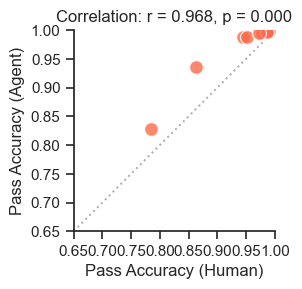

In [10]:
human_vals = np.array(all_pass_rate_a1).mean(axis=1).flatten()
agent_vals = np.array(all_pass_rate_a1_agent).mean(axis=1).flatten()

r, p = pearsonr(human_vals, agent_vals)

title_prefix="Correlation"
point_size=100
cmap = matplotlib.colormaps["Reds"]
color = cmap(0.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([0.65, 1], [0.65, 1], linestyle='dotted', color='gray', alpha=0.6, zorder=0)
ax.scatter(human_vals, agent_vals, color=color, edgecolor='white', s=point_size, zorder=1, alpha=0.8)
ax.set_xlabel("Pass Accuracy (Human)")
ax.set_ylabel("Pass Accuracy (Agent)")
ax.set_xlim(0.65, 1)
ax.set_ylim(0.65, 1)
ax.set_xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_yticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_aspect('equal', adjustable='box')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.tick_params(
    axis='both', direction='out', length=6, width=1.2,
    bottom=True, top=False, left=True, right=False
)
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
ax.set_title(f"{title_prefix}: r = {r:.3f}, p = {p:.3f}")
plt.tight_layout()

plt.show()


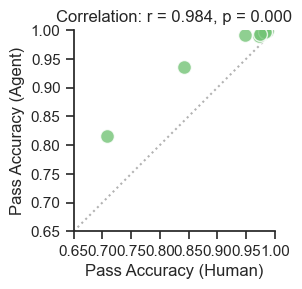

In [11]:
human_vals = np.array(all_pass_rate_a2).mean(axis=1).flatten()
agent_vals = np.array(all_pass_rate_a2_agent).mean(axis=1).flatten()

r, p = pearsonr(human_vals, agent_vals)

title_prefix="Correlation"
point_size=100
cmap = matplotlib.colormaps["Greens"]
color = cmap(0.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([0.65, 1], [0.65, 1], linestyle='dotted', color='gray', alpha=0.6, zorder=0)
ax.scatter(human_vals, agent_vals, color=color, edgecolor='white', s=point_size, zorder=1, alpha=0.8)
ax.set_xlabel("Pass Accuracy (Human)")
ax.set_ylabel("Pass Accuracy (Agent)")
ax.set_xlim(0.65, 1)
ax.set_ylim(0.65, 1)
ax.set_xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_yticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_aspect('equal', adjustable='box')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.tick_params(
    axis='both', direction='out', length=6, width=1.2,
    bottom=True, top=False, left=True, right=False
)
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
ax.set_title(f"{title_prefix}: r = {r:.3f}, p = {p:.3f}")
plt.tight_layout()

plt.show()


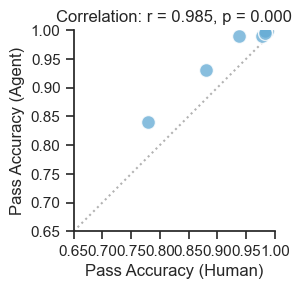

In [12]:
human_vals = np.array(all_pass_rate_a3).mean(axis=1).flatten()
agent_vals = np.array(all_pass_rate_a3_agent).mean(axis=1).flatten()

r, p = pearsonr(human_vals, agent_vals)

title_prefix="Correlation"
point_size=100
cmap = matplotlib.colormaps["Blues"]
color = cmap(0.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([0.65, 1], [0.65, 1], linestyle='dotted', color='gray', alpha=0.6, zorder=0)
ax.scatter(human_vals, agent_vals, color=color, edgecolor='white', s=point_size, zorder=1, alpha=0.8)
ax.set_xlabel("Pass Accuracy (Human)")
ax.set_ylabel("Pass Accuracy (Agent)")
ax.set_xlim(0.65, 1)
ax.set_ylim(0.65, 1)
ax.set_xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_yticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_aspect('equal', adjustable='box')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.tick_params(
    axis='both', direction='out', length=6, width=1.2,
    bottom=True, top=False, left=True, right=False
)
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
ax.set_title(f"{title_prefix}: r = {r:.3f}, p = {p:.3f}")
plt.tight_layout()

plt.show()
